# Общий конвейер

In [1]:
import numpy as np
import keras
import pandas as pd

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D

from keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import TweetTokenizer

import pyodbc

from re import sub

Using TensorFlow backend.


## 1. Загрузка данных

In [2]:
import pandas
df_train = pandas.read_csv("data/train.csv")
df_test  = pandas.read_csv("data/test.csv")
df_val   = pandas.read_csv("data/val.csv")

In [3]:
df_train.describe()

,id,class
count,181467.000000,181467.000000
mean,90733.000000,0.505993
std,52385.154987,0.499965
min,0.000000,0.000000
25%,45366.500000,0.000000
50%,90733.000000,1.000000
75%,136099.500000,1.000000
max,181466.000000,1.000000


## 2. Токенизация
Кодируем слова индексами (вычисленными по частоте употребления).
Using russian http://www.ruscorpora.ru/en/

from keras.preprocessing.text import Tokenizer Убираем, потому что он режет символы пунктуации
#### Step 1. Clear dataset. 
Select words one by one. Symbols are meaningful because of smiles and emotions.

We will create a HashMap by using a Python dictionary to store the word frequencies of a book.
A dictionary is an associative array (also known as hashes).
Any key of the dictionary is associated, or mapped, to a value.
The values of a dictionary can be any Python data type, so dictionaries are unordered key-value-pairs.

By creating the dictionary, we will store the words as the keys and the value will represent the count. By doing this, we can retrieve any word without having to recount every single word.

#### Step 2. Select meaningful words.
#### Step 3. Calculate frequency of each word
#### Step 4. Replace words by indexes

In [4]:
import nltk
import string
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize

hash_map = {}

In [8]:
class SentimentAnalysis:
    max_words = 2000
    batch_size = 32
    epochs = 30
    max_len = 40
    cnstr = 'Trusted_Connection=yes;DRIVER={SQL Server};SERVER=GORDAPC\MSSQLSERVER2017;DATABASE=InnaDB;UID=sa;PWD=49649952'
    map = {}
    x_train, y_train, x_test, y_test = ([] for i in range(4))

    def data_generator(self, constring, query):
        cnxn = pyodbc.connect(constring)
        cursor = cnxn.cursor()
        cursor.execute(query)

        y, t = [], []
        for row in cursor:
            r_text = row.ttext
            r_type = row.ttype
            y.append(r_text)
            t.append(r_type)

            if len(y) == self.batch_size:
                npx = np.array(y)
                npy = np.array(t)
                yield npx, npy
                y, t = [], []
        pyodbc.Connection.close(cnxn)
    
    def tokenize(self, file_text):
        if file_text is not None:
            #firstly let's apply nltk tokenization
            #tokens = nltk.word_tokenize(file_text)
            #упоминания
            file_text = sub(r'@\w+', "", file_text) 
            #ссылки
            file_text = sub(r'http[^\s]+', "", file_text)
            #хэштеги
            file_text = sub(r'#\w+', "", file_text)
            #RT
            file_text = sub(r'RT +: +', "", file_text)
            #\n
            file_text = sub(r'\n', " ", file_text)


            tknzr = TweetTokenizer()
            tokens = tknzr.tokenize(file_text)

            #let's delete punctuation symbols
            stop_words = ([',','\\','/','*','','-','http',';',':','@',',','.','#','"','n','—','_'])
            tokens = [i for i in tokens if ( i not in stop_words )]
            
            tokens = [i for i in tokens if not i.isdigit() ]

            #deleting stop_words
            stop_words = list(set(stopwords.words('russian'))-set(['не','лучше','больше','никогда','хорошо']))
            #stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'в', '—', 'к', 'на', 'http', 'чем', 'х','ж','же','\\n','\\nя'
            #                   ,'еще','ещё','d','rt'])

            tokens = [i for i in tokens if ( i not in stop_words )]

            #cleaning words
            #tokens = [i.replace("«", "").replace("»", "") for i in tokens]
            
            return tokens
        else:
            return None
    
    def map_words(self, tokens):
        if tokens is not None:
            for word in tokens:
                word = word.lower()
                # Word Exist?
                if word in hash_map:
                    hash_map[word] = hash_map[word] + 1
                else:
                    hash_map[word] = 1

            return hash_map
        else:
            return None
        
    def frequency_mapping(self):
        hash_map.clear()

        query = "SELECT [ttext], [ttype] FROM [dbo].[sentiments]"
        pdg = self.data_generator(self.cnstr, query)


        for current_set in pdg:
            for sentence in current_set[0]:
                words = self.tokenize(sentence)
                self.map = self.map_words(words)
        most_popular_words = sorted(self.map, key=self.map.get, reverse=True)[:self.max_words]
        indexes = list(range(0, self.max_words))
        self.map = dict( zip( most_popular_words, indexes))
        #{key: value for key, value in self.map.items() if key in most_popular_words}
    
    def get_frequency(self, word):
        for word in word_list:
            print( str(self.map.get(word,0)))
    
    def vectorize(self,data):
        max_frequency = max(self.map.values())
        
        x_data = []
        
        for index, row in data.iterrows():
            if pd.isnull(row.text):
                words = sa.tokenize('')
            else:
                words = sa.tokenize(row.text)
            w = []
            #print(words)
            for word in words:
                #print(word, map.get(word,0))
                w.append(self.map.get(word,0))
            x_data.append(w)

        x_data = np.array(x_data)
        x_data = pad_sequences(x_data, maxlen=self.max_len)
        #print(x_train)
        return x_data
    
    def tokenize_message(self, string):
        words = self.tokenize(string)
        res = []
        for word in words:
            res.append(self.map.get(word,0))
        ntm = np.array([res])

        nres = pad_sequences(ntm, maxlen=self.max_len)
            #res.append([word_2_ind[w] for w in sent.split(' ')])
        return nres#np.pad(ntm, (maxlen-len(ntm),0),'constant', constant_values=(0))
    
    def getRating(self, value):
        return {
             value < 0.2: 'Крайне негативная оценка',
             0.2 <= value < 0.4: 'Негативная оценка',
             0.4 <= value < 0.6: 'Нейтральная оценка',
             0.6 <= value < 0.8: 'Положительная оценка',
             0.8 <= value:       'Крайне положительная оценка'
        }[True]
    
    def sentiment(self, model, text):
        inp = np.array(self.tokenize_message(text), dtype=np.int32)
        p = model.predict(inp)
        return self.getRating(p[0][0]), p[0][0]

In [9]:
sa = SentimentAnalysis()

создание словаря

In [10]:
sa.frequency_mapping()

In [11]:
sa.map

{'!': 0,
 'не': 1,
 ')': 2,
 '?': 3,
 '...': 4,
 'это': 5,
 'я': 6,
 '(': 7,
 'в': 8,
 '…': 9,
 '«': 10,
 '..': 11,
 '»': 12,
 'а': 13,
 'и': 14,
 'сегодня': 15,
 'просто': 16,
 ':)': 17,
 ':d': 18,
 'хочу': 19,
 'день': 20,
 'тебе': 21,
 'скачать': 22,
 'как': 23,
 'очень': 24,
 'с': 25,
 'больше': 26,
 'спасибо': 27,
 'на': 28,
 'у': 29,
 'всё': 30,
 '^': 31,
 'люблю': 32,
 'ты': 33,
 'год': 34,
 'почему': 35,
 'ну': 36,
 'новый': 37,
 'человек': 38,
 '–': 39,
 'мне': 40,
 'время': 41,
 'если': 42,
 'завтра': 43,
 'россии': 44,
 'люди': 45,
 'буду': 46,
 'класс': 47,
 'всем': 48,
 'года': 49,
 'вообще': 50,
 'что': 51,
 'все': 52,
 'хорошо': 53,
 'жизнь': 54,
 '&': 55,
 'кто': 56,
 'жизни': 57,
 'видео': 58,
 'но': 59,
 'лучше': 60,
 'могу': 61,
 'фото': 62,
 'вот': 63,
 'да': 64,
 'никогда': 65,
 'знаю': 66,
 'нужно': 67,
 'спать': 68,
 'смотреть': 69,
 'фильм': 70,
 'бесплатно': 71,
 'людей': 72,
 'дома': 73,
 'о': 74,
 'пока': 75,
 'з': 76,
 'онлайн': 77,
 'лет': 78,
 'которые': 7

In [12]:
from keras.preprocessing import sequence

print('Vectorizing sequence data...')
x_train = sa.vectorize(df_train)
x_test  = sa.vectorize(df_test )
x_val   = sa.vectorize(df_val  )


Vectorizing sequence data...


In [13]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (181467, 40)
x_test shape: (22684, 40)


In [14]:
x_train

array([[  0,   0,   0, ..., 471,   0,  18],
       [  0,   0,   0, ...,   0, 271,   7],
       [  0,   0,   0, ...,   0,   2,   2],
       ..., 
       [  0,   0,   0, ...,   0,   0, 101],
       [  0,   0,   0, ...,  60,   0,  17],
       [  0,   0,   0, ...,   0,   0, 101]])

In [47]:
print('Convert class vector to binary class matrix '
      '(for use with categorical_crossentropy)')
num_classes = 2
y_train = keras.utils.to_categorical(df_train["class"], num_classes)
y_val = keras.utils.to_categorical(df_val["class"], num_classes)
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)

Convert class vector to binary class matrix (for use with categorical_crossentropy)
y_train shape: (181467, 2)
y_val shape: (22683, 2)


In [48]:
y_val

array([[ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       ..., 
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.]])

In [49]:
print('Building model sequentially 1...')
model = Sequential()
model.add(Embedding(input_dim=sa.max_words, output_dim=128, input_length=sa.max_len))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(num_classes))
model.add(Activation('softmax'))

Building model sequentially 1...


In [50]:
model.layers

In [51]:
print(model.to_yaml())

backend: tensorflow
class_name: Sequential
config:
- class_name: Embedding
  config:
    activity_regularizer: null
    batch_input_shape: !!python/tuple [null, 40]
    dtype: float32
    embeddings_constraint: null
    embeddings_initializer:
      class_name: RandomUniform
      config: {maxval: 0.05, minval: -0.05, seed: null}
    embeddings_regularizer: null
    input_dim: 2000
    input_length: 40
    mask_zero: false
    name: embedding_2
    output_dim: 128
    trainable: true
- class_name: Conv1D
  config:
    activation: linear
    activity_regularizer: null
    bias_constraint: null
    bias_initializer:
      class_name: Zeros
      config: {}
    bias_regularizer: null
    dilation_rate: !!python/tuple [1]
    filters: 128
    kernel_constraint: null
    kernel_initializer:
      class_name: VarianceScaling
      config: {distribution: uniform, mode: fan_avg, scale: 1.0, seed: null}
    kernel_regularizer: null
    kernel_size: !!python/tuple [3]
    name: conv1d_2
    padd

In [52]:
import graphviz
import pydot_ng as pydot
print (pydot.find_graphviz())

{'dot': 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\dot.exe', 'twopi': 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\twopi.exe', 'neato': 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\neato.exe', 'circo': 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\circo.exe', 'fdp': 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\fdp.exe', 'sfdp': 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\sfdp.exe'}


In [53]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

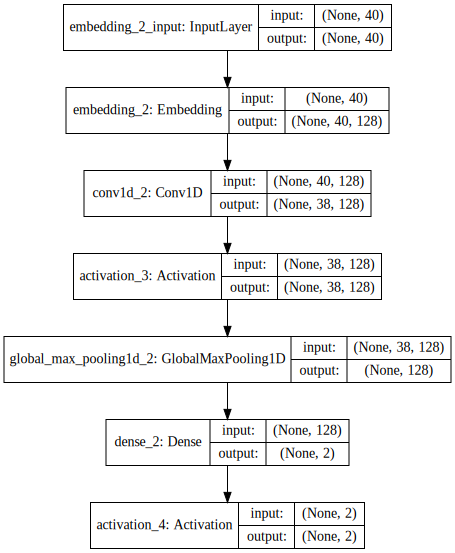

In [54]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [55]:
from keras.objectives import categorical_crossentropy
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [56]:
from keras.callbacks import TensorBoard  
tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
from keras.callbacks import EarlyStopping  
early_stopping=EarlyStopping(monitor='val_loss', patience=3)  


history = model.fit(x_train, y_train,
                    batch_size=sa.batch_size,
                    epochs=sa.epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

Train on 163320 samples, validate on 18147 samples
Epoch 1/30
163320/163320 [==============================] - 18s 107us/step - loss: 0.0461 - acc: 0.9858 - val_loss: 0.0424 - val_acc: 0.9863
Epoch 2/30
163320/163320 [==============================] - 17s 106us/step - loss: 0.0326 - acc: 0.9893 - val_loss: 0.0421 - val_acc: 0.9872
Epoch 3/30
163320/163320 [==============================] - 17s 105us/step - loss: 0.0269 - acc: 0.9910 - val_loss: 0.0484 - val_acc: 0.9867
Epoch 4/30
163320/163320 [==============================] - 17s 103us/step - loss: 0.0220 - acc: 0.9928 - val_loss: 0.0534 - val_acc: 0.9862
Epoch 5/30
163320/163320 [==============================] - 17s 106us/step - loss: 0.0185 - acc: 0.9938 - val_loss: 0.0723 - val_acc: 0.9853


In [57]:
score = model.evaluate(x_val, y_val, batch_size=sa.batch_size, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

22683/22683 [==============================] - 1s 37us/step


Test score: 0.0650629415337
Test accuracy: 0.986686064454


In [58]:
results = model.predict(x_test, batch_size=sa.batch_size, verbose=1)

22684/22684 [==============================] - 1s 27us/step


In [66]:
#sa.sentiment(model,'Мне не нравится фильм. Сюжет совсем неинтересный и актеры сыграли плохо')

#x_text = pad_sequences(x_text, maxlen=sa.max_len)

#model.predict(x_text)
inp = np.array(sa.tokenize_message('Мне нравится фильм. Отличная игра актеров и интересный сюжет'), dtype=np.int32)
p = model.predict(inp)
p

array([[ 0.98367172,  0.01632828]], dtype=float32)

In [60]:
print('x_train shape:', x_text.shape)

NameError: name 'x_text' is not defined

In [67]:
df_train['text'][0]

'Делаю пробное печенье по рецепту makeupkaty , пока что без формы) http://t.co/bRZjtMdXyd'